In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Function

import os
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import random

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Lớp đệm ảnh: Tránh resize ảnh bị biến dạng
class SquarePad:
    def __call__(self, image: Image.Image) -> Image.Image:
        w, h = image.size
        max_wh = max(w, h)

        # Tính toán padding
        left = (max_wh - w) // 2
        top = (max_wh - h) // 2
        right = max_wh - w - left
        bottom = max_wh - h - top

        # Đệm ảnh bằng vùng màu đen
        return ImageOps.expand(image, (left, top, right, bottom), fill=0)

In [3]:
class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            # Lưu ý: subset trả về ảnh chưa transform hoặc đã transform 
            # nên tốt nhất khởi tạo ImageFolder với transform=None
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [4]:
# Khởi tạo dữ liệu: train - valid - test
TRAIN_PATH = "/kaggle/input/pneumonia-detect-dataset/chest_xray/train"
VALID_PATH = "/kaggle/input/pneumonia-detect-dataset/chest_xray/val"
TEST_PATH = "/kaggle/input/pneumonia-detect-dataset/chest_xray/test"
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1

# Khởi tạo target transformation
target_transform = transforms.Compose([
    SquarePad(),
    transforms.RandomResizedCrop(size=224, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1), # Biến đổi màu sắc
    transforms.RandomGrayscale(p=0.5), # Mô phỏng ảnh X-quang cũ
    transforms.GaussianBlur(kernel_size=5), # Mô phỏng ảnh bị mờ/nhiễu
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Khởi tạo source transformation
source_transform = transforms.Compose([
    SquarePad(),
    transforms.Resize(size=224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Khởi tạo valid và test transformation
val_transform = transforms.Compose([
    SquarePad(),
    transforms.Resize(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Khởi tạo dataset
print(f'===============================================================')
train_dataset = ImageFolder(root=TRAIN_PATH)
print(f'Length of train dataset: {len(train_dataset)}')

valid_dataset = ImageFolder(root=VALID_PATH, transform=val_transform)
print(f'Length of valid dataset: {len(valid_dataset)}')

test_dataset = ImageFolder(root=TEST_PATH, transform=val_transform)
print(f'Length of test dataset: {len(test_dataset)}')
print(f'===============================================================')

print()

# Chia đôi dữ liệu train thành source và target
train_size = len(train_dataset)
indices = list(range(train_size))
split = train_size // 2

# Trộn dữ liệu trước khi chia
random.shuffle(indices)
source_indices = indices[:split]
target_indices = indices[split:]

# Tạo hai tập dữ liệu với hai bộ transform khác nhau
source_dataset = ApplyTransform(Subset(train_dataset, source_indices), transform=source_transform)
target_dataset = ApplyTransform(Subset(train_dataset, target_indices), transform=target_transform)

# Khởi tạo dataloader
print(f'===============================================================')
source_loader = DataLoader(source_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2, persistent_workers=True)
print(f'Length of source dataloader: {len(source_loader)}')

target_loader = DataLoader(target_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2, persistent_workers=True)
print(f'Length of target dataloader: {len(target_loader)}')

valid_loader = DataLoader(dataset=valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2, persistent_workers=True)
print(f'Length of valid dataloader: {len(valid_loader)}')

test_loader = DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2, persistent_workers=True)
print(f'Length of test dataloader: {len(test_loader)}')
print(f'===============================================================')


Length of train dataset: 6557
Length of valid dataset: 16
Length of test dataset: 624

Length of source dataloader: 52
Length of target dataloader: 52
Length of valid dataloader: 16
Length of test dataloader: 624


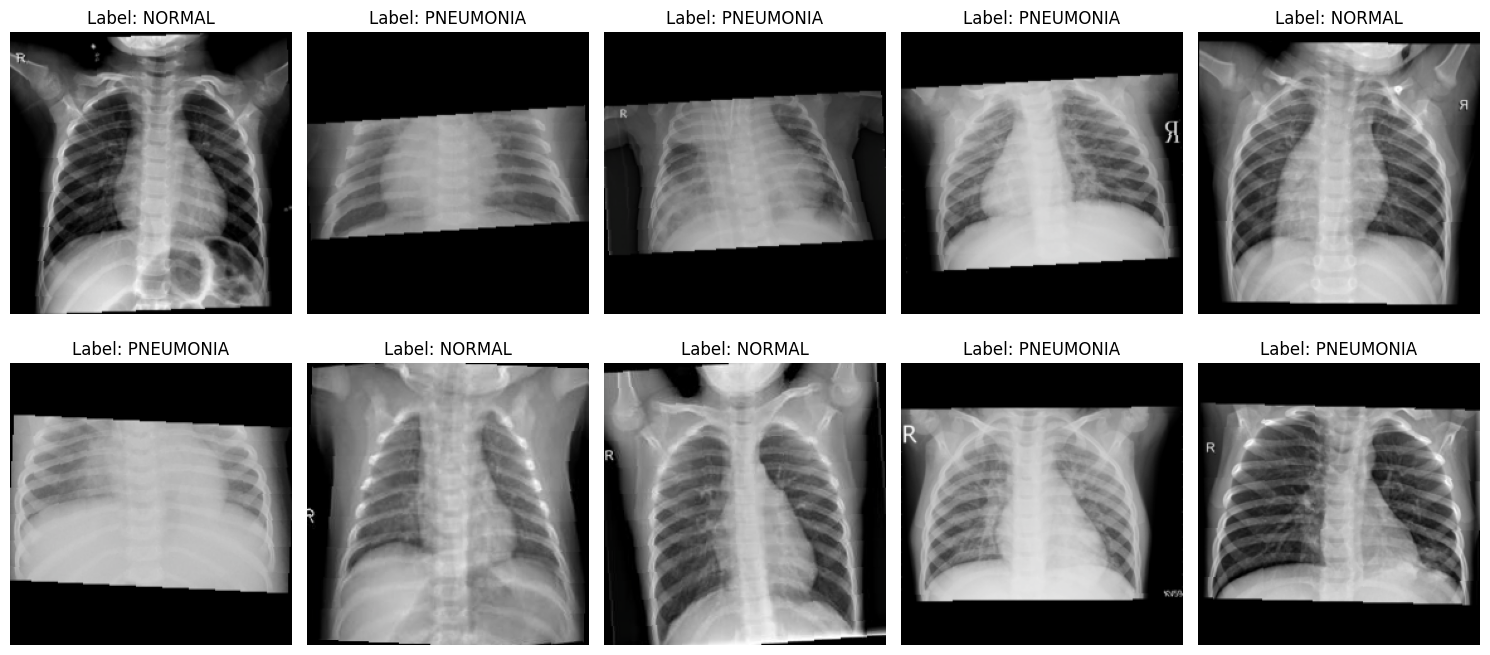

In [5]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize_for_display(image_tensor):
    """Biến đổi tensor từ normalized về numpy [0, 1] để plt.imshow"""
    # Chuyển từ (C, H, W) -> (H, W, C)
    image = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Đảo ngược Normalize: image * std + mean
    image = image * STD + MEAN

    # Đảm bảo giá trị nằm trong khoảng [0, 1] để tránh lỗi hiển thị
    image = np.clip(image, 0, 1)
    return image

# --- Trực quan hóa dữ liệu tập source ---

# Lấy 1 mẫu batch từ source dataset
images, labels = next(iter(source_loader))

# Visualize các mẫu ảnh cùng với nhãn
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.ravel()

for i, ax in enumerate(axes):
    # Sử dụng hàm denormalize đã viết ở trên
    img_to_show = denormalize_for_display(images[i])

    ax.imshow(img_to_show)

    # Lấy tên label từ dataset (nếu labels là index)
    label_name = train_dataset.classes[labels[i]]
    ax.set_title(f"Label: {label_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()

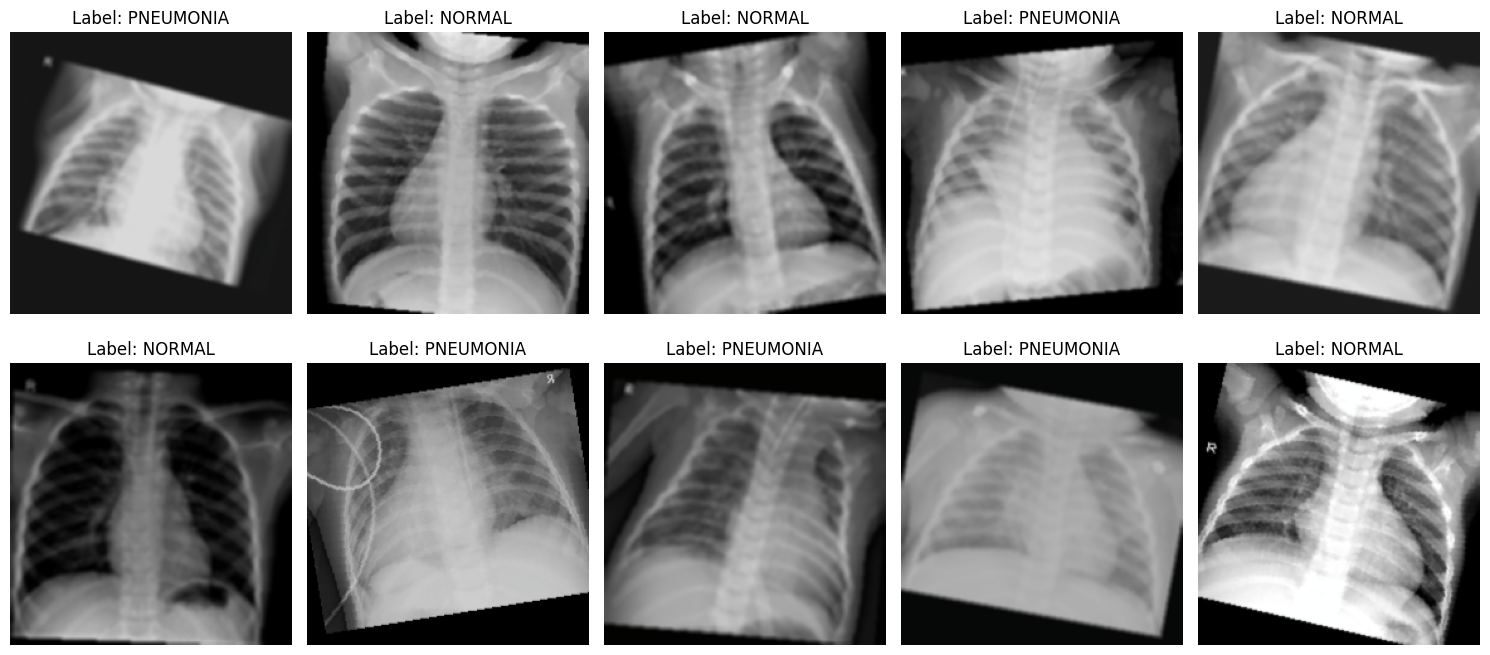

In [6]:
# --- Trực quan hóa dữ liệu tập source ---

# Lấy 1 mẫu batch từ target dataset
images, labels = next(iter(target_loader))

# Visualize các mẫu ảnh cùng với nhãn
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.ravel()

for i, ax in enumerate(axes):
    # Sử dụng hàm denormalize đã viết ở trên
    img_to_show = denormalize_for_display(images[i])

    ax.imshow(img_to_show)

    # Lấy tên label từ dataset (nếu labels là index)
    label_name = train_dataset.classes[labels[i]]
    ax.set_title(f"Label: {label_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Định nghĩa lớp Gradient Reversal Function (GRF)
class GradientReversalFn(Function):
    
    # Hàm chiều xuôi
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha # cất giá trị alpha vào để dùng cho backward
        return x.view_as(x)
    
    # Hàm chiều ngược
    @staticmethod
    def backward(ctx, grad_output):
        # Đảo ngược gradient bằng cách nhân với - alpha
        # alpha là hệ số điều chỉnh để kiểm soát cường độ của việc đảo ngược
        output = grad_output.neg() * ctx.alpha
        return output, None

# Định nghĩa lớp Gradient Reversal Layer (GRL)
class GRL(nn.Module):
    def __init__(self, alpha=1.0):
        super(GRL, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalFn.apply(x, self.alpha)

# Định nghĩa DANN
class DANN(nn.Module):
    def __init__(self, num_classes=2):
        super(DANN, self).__init__()
        
        # Khởi tạo features extractor: Gf() sử dụng resnet50
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        feature_size = resnet.fc.in_features
        
        # Khởi tạo label classifier: Gy()
        self.label_classifier = nn.Sequential(
            nn.Linear(in_features=feature_size, out_features=512, bias=True),
            nn.LayerNorm(normalized_shape=512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(in_features=512, out_features=num_classes)
        )
        
        # Khởi tạo domain discriminator: Gd()
        self.domain_discriminator = nn.Sequential(
            nn.Linear(in_features=feature_size, out_features=512, bias=True),
            nn.LayerNorm(normalized_shape=512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(in_features=512, out_features=num_classes) # 0: Source, 1: Target
        )
        
    def forward(self, x: torch.tensor, alpha: float =1.0, mode='train'):
        # Trích xuất đặc trưng
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        
        # Phân loại nhãn
        label_output = self.label_classifier(features)

        if mode == "train":
            # Phân biệt domain
            reverse_features = GradientReversalFn.apply(features, alpha)
            domain_output = self.domain_discriminator(reverse_features)
            
            return label_output, domain_output
        if mode == "test" or mode == "valid":
            return label_output

In [8]:
# Khởi tạo cấu hình tham số
LEARNING_RATE_MAX = 0.01
LEARNING_RATE_MIN = 0.0001
WEIGHT_DECAY = 0.0001
NUM_EPOCHES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2

# Khởi tạo mô hình
model = DANN(num_classes=NUM_CLASSES).to(DEVICE)

# Khởi tạo hàm mất mát
criterion_label = nn.CrossEntropyLoss().to(DEVICE)
criterion_domain = nn.CrossEntropyLoss().to(DEVICE)

# Khởi tại hàm tối ưu
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE_MAX, weight_decay=WEIGHT_DECAY)

# Khởi tạo hàm lập lịch
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=LEARNING_RATE_MAX, eta_min=LEARNING_RATE_MIN)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [9]:
# Huấn luyện mô hình

# Lưu chỉ số
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []

# Theo dõi tiến trình
epoch_bar = tqdm(desc='Epochs', total=NUM_EPOCHES, position=0)
train_bar = tqdm(desc='Train', total=len(source_loader), position=1, leave=False)
valid_bar = tqdm(desc='Valid', total=len(valid_loader), position=1, leave=False)

for epoch in range(NUM_EPOCHES):
    train_acc_batch = []
    train_loss_batch = []
    valid_acc_batch = []
    valid_loss_batch = []

    # Lập lịch cho alpha (tăng dần từ 0 đến 1)
    alpha = epoch / (NUM_EPOCHES - 1)

    # --- PHASE: TRAIN ---
    model.train()
    for (src_imgs, src_labels), (tgt_imgs, _) in zip(source_loader, target_loader):
        # Chuyển dữ liệu sang thiết bị để tính toán
        src_imgs, src_labels, tgt_imgs = src_imgs.to(DEVICE), src_labels.to(DEVICE), tgt_imgs.to(DEVICE)

        # Làm mới hàm tối ưu
        optimizer.zero_grad()
        
        # 1. Huấn luyện với Source Data 
        batch_size = src_imgs.shape[0]
        src_domain_labels = torch.zeros(batch_size).long().to(DEVICE) # Nhãn domain = 0
        
        src_label_out, src_domain_out = model(src_imgs, alpha)
        loss_label = criterion_label(src_label_out, src_labels)
        loss_src_domain = criterion_domain(src_domain_out, src_domain_labels)

        # Huấn luyện với Target Data 
        batch_size = tgt_imgs.shape[0]
        tgt_domain_labels = torch.ones(batch_size).long().to(DEVICE) # Nhãn domain = 1
        
        _, tgt_domain_out = model(tgt_imgs, alpha)
        loss_tgt_domain = criterion_domain(tgt_domain_out, tgt_domain_labels)

        # Tổng hợp Loss và Backward
        total_loss = loss_label + loss_src_domain + loss_tgt_domain
        total_loss.backward()
        optimizer.step()

        # Theo dõi giá trị loss theo từng batch
        train_loss_batch.append(total_loss.item())

        # Theo dõi giá trị acc theo từng batch
        y_pred_idx = torch.max(src_label_out, dim=1).indices
        acc = (y_pred_idx == src_labels).float().mean().item()
        train_acc_batch.append(acc)

        # Cập nhập thanh tiến trình
        train_bar.set_postfix(src_domain_loss=f'{loss_src_domain:.2f}', tgt_domain_loss=f'{loss_tgt_domain:.2f}', label_los=f'{loss_label:.2f}', alpha=f'{alpha:.2f}')
        train_bar.update()

    # --- PHASE: VALID ---
    model.eval()
    with torch.no_grad():
        for batch in valid_loader:
            images, labels = batch
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            y_pred = model(images, mode='valid')
            loss = criterion_label(y_pred, labels)

            valid_loss_batch.append(loss.item())

            y_pred_idx = torch.max(y_pred, dim=1).indices
            acc = (y_pred_idx == labels).float().mean().item()
            valid_acc_batch.append(acc)

            valid_bar.set_postfix(acc=f'{acc:.2f}', loss=f'{loss.item():.2f}')
            valid_bar.update()

    # Cập nhật Scheduler sau mỗi epoch
    scheduler.step()

    # Tổng hợp chỉ số epoch
    avg_train_acc = np.mean(train_acc_batch)
    avg_train_loss = np.mean(train_loss_batch)
    avg_valid_acc = np.mean(valid_acc_batch)
    avg_valid_loss = np.mean(valid_loss_batch)

    train_acc.append(avg_train_acc)
    train_loss.append(avg_train_loss)
    valid_acc.append(avg_valid_acc)
    valid_loss.append(avg_valid_loss)

    # Reset thanh tiến trình cho epoch sau
    train_bar.n = 0
    valid_bar.n = 0
    train_bar.last_print_n = 0
    valid_bar.last_print_n = 0
    epoch_bar.update()

    print(f'\nEpoch {epoch+1}/{NUM_EPOCHES}')
    print(f'Train -> Acc: {avg_train_acc:.4f}, Loss: {avg_train_loss:.4f}')
    print(f'Valid -> Acc: {avg_valid_acc:.4f}, Loss: {avg_valid_loss:.4f}')
    print("-" * 30)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/52 [00:00<?, ?it/s]

Valid:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/10
Train -> Acc: 0.8521, Loss: 1.9405
Valid -> Acc: 0.5625, Loss: 1.7697
------------------------------

Epoch 2/10
Train -> Acc: 0.9241, Loss: 1.5485
Valid -> Acc: 0.5625, Loss: 1.3507
------------------------------

Epoch 3/10
Train -> Acc: 0.9373, Loss: 1.5197
Valid -> Acc: 0.5625, Loss: 1.3645
------------------------------

Epoch 4/10
Train -> Acc: 0.9433, Loss: 1.5622
Valid -> Acc: 0.3125, Loss: 1.6087
------------------------------

Epoch 5/10
Train -> Acc: 0.9438, Loss: 1.5212
Valid -> Acc: 0.6250, Loss: 1.2778
------------------------------

Epoch 6/10
Train -> Acc: 0.9466, Loss: 1.5324
Valid -> Acc: 0.6875, Loss: 0.8703
------------------------------

Epoch 7/10
Train -> Acc: 0.9499, Loss: 1.5241
Valid -> Acc: 0.5625, Loss: 1.2329
------------------------------

Epoch 8/10
Train -> Acc: 0.9487, Loss: 1.5279
Valid -> Acc: 0.5625, Loss: 1.5481
------------------------------

Epoch 9/10
Train -> Acc: 0.9507, Loss: 1.5253
Valid -> Acc: 0.6250, Loss: 1.5252
--------------

In [10]:
def test_model(model, dataloader, device='cuda'):
    model.eval()  # Chuyển sang chế độ đánh giá (tắt Dropout, Batchnorm)

    all_preds = []
    all_labels = []

    with torch.no_grad(): # Tắt tính toán gradient để tiết kiệm bộ nhớ và nhanh hơn
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images, mode='valid')

            # Lấy index của class có xác suất cao nhất
            _, preds = torch.max(outputs, 1)

            # Lưu kết quả về CPU để tính toán bằng sklearn
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Tính toán các chỉ số
    # 'macro': Tính trung bình cho từng lớp rồi chia đều (phù hợp nếu các lớp quan trọng như nhau)
    # 'weighted': Tính trung bình có trọng số theo số lượng mẫu của mỗi lớp
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='macro',
        zero_division=0
    )

    print(f"Test Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

    return precision, recall, f1

In [11]:
# Test hiệu quả mô hình
p, r, f1 = test_model(model, test_loader, device=DEVICE)

Test Results:
Precision: 0.8081
Recall:    0.8286
F1-score:  0.8060
